### Decoding Extrastriate

In [21]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from palettable.matplotlib import Inferno_3 as ColMap
from src.config import SUBJECTS, SESSION, N_LAYER
from src.stats import Bootstrap, fdr_correction
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
FILTER_SIZE = "none"

# set
SESS = "SE_EPI"
PART = 2  # 0, 1, or 2
AREA = ["v2a", "v2b"]

In [22]:
def get_profile(area, sess, day):
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        path = Path(DIR_DATA) / subj / f"{sess}{SESSION[subj][sess][day]}"
        file = path / f"bandpass_{FILTER_SIZE}_{area}" / "accuracy.csv"
        data = np.genfromtxt(file, delimiter=',')
        for j in range(N_LAYER):
            y[j, i] = np.mean(data[j, :] * 100)
    return y

In [23]:
x = np.linspace(0, 1, N_LAYER)
data = []
p_adj = []
for area in AREA:
    y1 = get_profile(area, SESS, 0)
    y2 = get_profile(area, SESS, 1)
    y3 = np.append(y1, y2, axis=1)
    if PART == 0:
        data.append(np.mean(y1, axis=1))
    elif PART == 1:
        data.append(np.mean(y2, axis=1))
    elif PART == 2:
        data.append(np.mean(y3, axis=1))
    else:
        raise ValueError("Unknown part!")

    # get fdr-corrected p-values
    p_val = []
    for i in range(N_LAYER):
        if PART == 0:
            boot = Bootstrap(y1[i,:])
        elif PART == 1:
            boot = Bootstrap(y2[i,:])
        elif PART == 2:
            boot = Bootstrap(y3[i,:])
        else:
            raise ValueError("Unknown error!")

        p_val.append(boot.p_value())

    p_val = fdr_correction(p_val)
    p_adj.append(p_val)

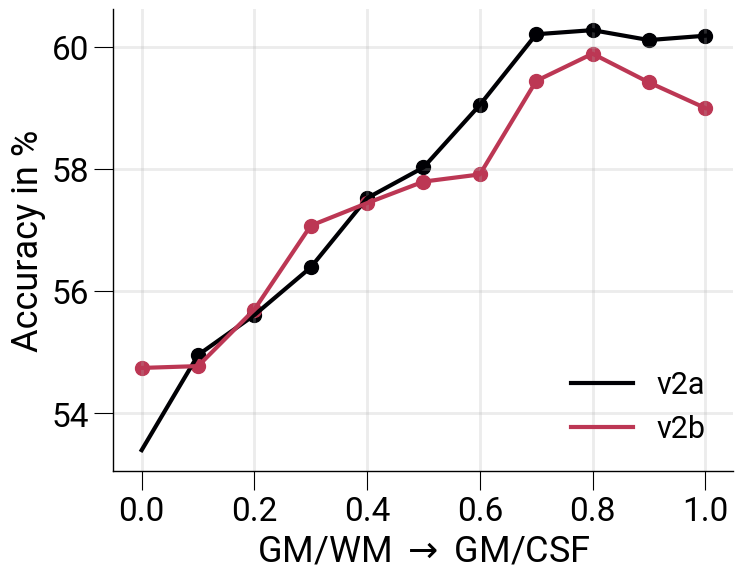

In [24]:
fig, ax = plt.subplots()
color = ColMap.hex_colors
for i, area in enumerate(AREA):
    ax.plot(x, data[i], color=color[i], linestyle="-", label=area, lw=3)
    ax.scatter(x[p_adj[i]<0.05], data[i][p_adj[i]<0.05], color=color[i], s=100)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Accuracy in %")
ax.legend(loc="lower right")
file_out = f"/data/pt_01880/decoding_{SESS}_{PART}_{AREA[0][:2]}.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")